In [1]:
import os
import numpy as np
import msa_hmm
from matplotlib import pyplot as plt

## MSA HMM Interactive

1. Fit n models, keep the best and align
2. Compare to a reference
3. Visualize the HMM

Change the variables in the following cell to fit your needs.

In [2]:
# your fasta file with unaligned sequences
train_filename = "test/data/bowman.fasta"
# if your file already contains gaps, change this flag to let them be removed
train_file_contains_gaps = False
# reference file with aligned sequences that have matching IDs to seqs in the train_file
# replace with empty string if no reference is available
ref_filename = "test/data/bowman.ref"
# number of independently trained models
num_runs = 1

## Training

In [3]:
# load the file
fasta_file = msa_hmm.fasta.Fasta(train_filename, 
                                 gaps=train_file_contains_gaps, 
                                 contains_lower_case=True)  
# optionally load the reference and find the corresponding sequences in the train file
if ref_filename != "":
    ref_fasta = msa_hmm.fasta.Fasta(ref_filename, gaps=True, contains_lower_case=True)
    subset = np.array([fasta_file.seq_ids.index(sid) for sid in ref_fasta.seq_ids])
else:
    subset = None
results = msa_hmm.align.fit_and_align_n(fasta_file, 
                                        num_runs=num_runs,
                                        config=msa_hmm.config.default,
                                        subset=subset)
best = np.argmax([ll for ll,_ in results])
best_ll, best_alignment = results[best]
print("Computed alignments with likelihoods:", [ll for ll,_ in results])
print("Best model has likelihood:", best_ll)
out_filepath = "test/data/interactive.alignment.fasta"
best_alignment.to_file(out_filepath)
if ref_filename != "":
    out_file = msa_hmm.fasta.Fasta(out_filepath, 
                             gaps=True, 
                             contains_lower_case=True) 
    _,r = out_file.precision_recall(ref_fasta)
    tc = out_file.tc_score(ref_fasta)
    print("SP score =", r, "TC score =", tc)

Training of 1 independent models on file bowman.fasta
Configuration:
transition_init : default , flank_init : default , emission_init : background
 , alpha_flank : 7000 , alpha_single : 1000000000.0 , alpha_frag : 10000.0
 , max_surgery_runs : 4 , length_init_quantile : 0.5 , surgery_quantile : 0.5
 , min_surgery_seqs : 10000.0 , len_mul : 0.8 , batch_size : adaptive
 , use_prior : True , dirichlet_mix_comp_count : 1 , use_anc_probs : True
 , tau_init : 0.0 , keep_tau : False
499 sequences of max. length 71
Fitting a model of length 20 on 499 sequences.
Batch size= 249 Learning rate= 0.1
Using 2 GPUs.
Epoch 1/2
30/30 - 11s - loss: 114.4674 - loglik: -7.0720e+01 - logprior: -4.3747e+01
Epoch 2/2
30/30 - 2s - loss: 60.9422 - loglik: -5.5275e+01 - logprior: -5.6676e+00
expansions: [(0, 4), (16, 2)]
discards: []
Fitting a model of length 26 on 499 sequences.
Batch size= 249 Learning rate= 0.1
Using 2 GPUs.
30/30 - 10s - loss: 104.8194 - loglik: -4.6549e+01 - logprior: -5.8270e+01
expansion

## Alignment

In [4]:
# print the alignment
max_seq = 20
msa = best_alignment.to_string()
for s in msa[:max_seq]:
    print(s)
if len(msa) > max_seq:
    print(len(msa) - max_seq, "sequences omitted.")

ddesskp$CCDQCACTKSNPPQCRCSDMrLNSCH$s.$ACKSCICALSYPAQCFCVDITDFCY$epckpseddken..
.sesskp$CCDQCSCTKSMPPKCRCSDIrNDFCY$..$-------------------------$epck..........
...yskp$CCDLCMCTRSMPPQCSCEDR.INSCH$sd$-CKSCMCTRSQPGQCRCLDTNDFCY$kpcksr........
....ksa$CCDTCLCTKSNPPTCRCVDV.GETCH$s.$ACLSCICAYSNPPKCQCFDTQKFCY$kqchnseleevikn
.......$---SCRCTKSIPPQCHC---.-----$..$-------------------------$..............


## Plot the consensus sequence logo of the trained model

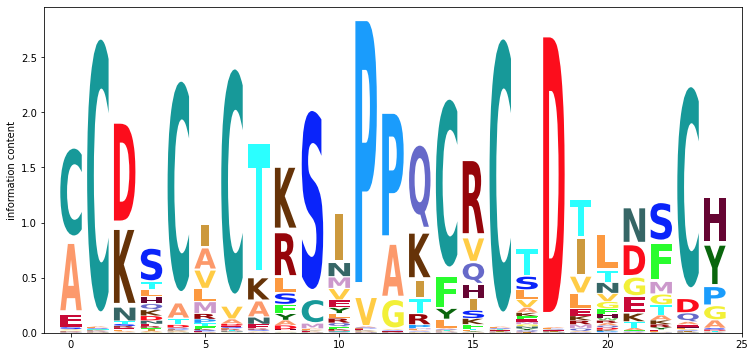

In [5]:
fig, ax = plt.subplots()
msa_hmm.vis.make_logo(best_alignment, ax)

## Plot the HMM plus a hidden sequence 

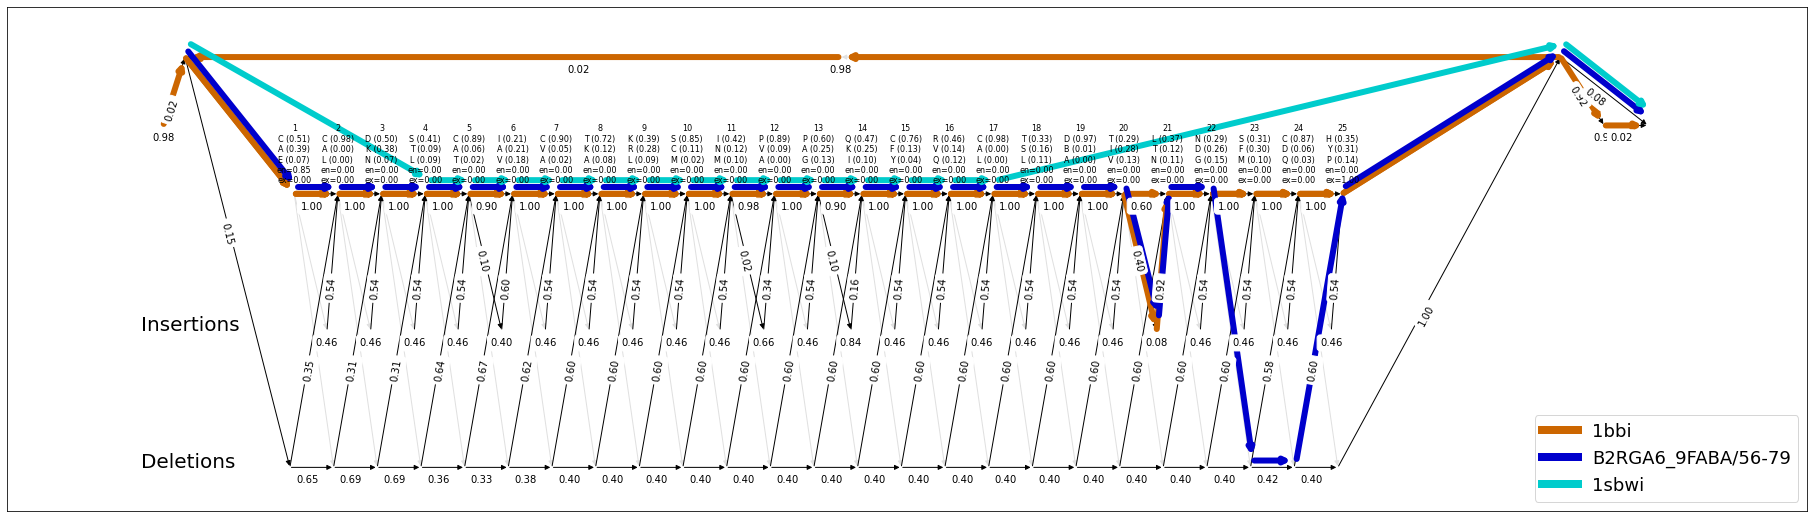

In [6]:
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
msa_hmm.vis.plot_hmm(best_alignment, ax, 
         seq_indices=[best_alignment.indices[0], 11, best_alignment.indices[-1]],
         path_colors=["#CC6600", "#0000cc", "#00cccc"])  #full domain length
plt.savefig("bowman_viterbi.pdf", bbox_inches='tight') 